# Linear regressions on spiracle data with a phylogenetic covariance matrix via MCMC

To begin with, we need to import necessary python packages.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api
import scipy.stats

import bokeh.io
import bokeh.plotting

from Bio import Phylo
import io

import cmdstanpy
import arviz as az

import bebi103

bokeh.io.output_notebook()

Loading BokehJS ...

We can now read in the data into a dataframe for analyis.

In [2]:
df = pd.read_csv("./20190322_supp_table_2.csv")

We take a look at the format for the data.

In [3]:
df['species_underscore'] = [spec.replace(" ", "_") for  spec in df['species']]
df.head()

subfamily                 species sex  mass (g) spiracle  area (mm^2)  \
0  Cetoniinae     Goliathus goliathus   M    16.280        6     0.274408   
1  Cetoniinae     Goliathus goliathus   F    18.150        6     0.134949   
2  Cetoniinae   Coelorrhina hornimani   M     1.130        6     0.212131   
3  Cetoniinae  Dicronorrhina derbyana   M     2.120        6     0.039532   
4  Cetoniinae  Dicronorrhina derbyana   F     2.145        6     0.049701   

   depth (mm)      species_underscore  
0    2.512648     Goliathus_goliathus  
1    1.606189     Goliathus_goliathus  
2    0.553833   Coelorrhina_hornimani  
3    0.473369  Dicronorrhina_derbyana  
4    0.496320  Dicronorrhina_derbyana

For some of this analysis, we will look at the per-species averages for our measurements. To get this, we use a simple aggregate function on the dataframe and take a look at the results.

In [4]:
df_averages = df.groupby(['species', 'species_underscore', 'spiracle'], as_index=False).aggregate(np.average)
df_averages['subfamily'] = df.groupby(['species', 'species_underscore', 'spiracle'], as_index=False).aggregate(max)['subfamily']
df_averages.head()

species     species_underscore spiracle  area (mm^2)  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1     0.135347   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2     0.084207   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3     0.106693   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4     0.115574   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5     0.119145   

   depth (mm)  mass (g)   subfamily  
0    0.416717      1.13  Cetoniinae  
1    0.451409      1.13  Cetoniinae  
2    0.325444      1.13  Cetoniinae  
3    0.481558      1.13  Cetoniinae  
4    0.506751      1.13  Cetoniinae

Let's take a look at the number of species per subfamily in the data.

In [5]:
species_per_subfam=df_averages.groupby(['subfamily', 'spiracle'], as_index=False).count().groupby('subfamily').aggregate(max).reset_index()[['subfamily', 'species']]
species_per_subfam.columns = ('subfamily', 'subfam_count')
species_per_subfam

subfamily  subfam_count
0  Cetoniinae             6
1  Dynastinae             3
2   Rutelinae             1

In [6]:
df_averages = df_averages.merge(species_per_subfam, on='subfamily')

For our plots, we will log transform the data. We will add a column to the dataframe with the log transformed data. We will also need some transforms of our data, which we will do here.

In [7]:
df_averages['log area (mm^2)'] = np.log10(df_averages['area (mm^2)'])
df_averages['log dist'] = np.log10(df_averages['depth (mm)'])
df_averages['log mass (g)'] = np.log10(df_averages['mass (g)'])
df_averages['log area/dist'] = np.log10(df_averages['area (mm^2)']/df_averages['depth (mm)'])
df_averages['log area^2/dist'] = np.log10(df_averages['area (mm^2)']**2/df_averages['depth (mm)'])

df_averages.head()

species     species_underscore spiracle  area (mm^2)  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1     0.135347   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2     0.084207   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3     0.106693   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4     0.115574   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5     0.119145   

   depth (mm)  mass (g)   subfamily  subfam_count  log area (mm^2)  log dist  \
0    0.416717      1.13  Cetoniinae             6        -0.868551 -0.380159   
1    0.451409      1.13  Cetoniinae             6        -1.074651 -0.345430   
2    0.325444      1.13  Cetoniinae             6        -0.971862 -0.487524   
3    0.481558      1.13  Cetoniinae             6        -0.937142 -0.317351   
4    0.506751      1.13  Cetoniinae             6        -0.923923 -0.295205   

   log mass (g)  log area/dist  log area^2/dist  
0      0.053078      -0.488392        -1.356943  
1      0.053078      -0.729221        -1.803872  
2      0.053078      -0.484339        -1.456201  
3      0.053078      -0.619790        -1.556932  
4      0.053078      -0.628717        -1.552640

In addition to log transforming the species averaged data, we will do the same for the whole data set.

In [8]:
df['log area (mm^2)'] = np.log10(df['area (mm^2)'])
df['log dist'] = np.log10(df['depth (mm)'])
df['log mass (g)'] = np.log10(df['mass (g)'])
df['log area/dist'] = np.log10(df['area (mm^2)']/df['depth (mm)'])
df['log area^2/dist'] = np.log10(df['area (mm^2)']**2/df['depth (mm)'])
df.head()

subfamily                 species sex  mass (g) spiracle  area (mm^2)  \
0  Cetoniinae     Goliathus goliathus   M    16.280        6     0.274408   
1  Cetoniinae     Goliathus goliathus   F    18.150        6     0.134949   
2  Cetoniinae   Coelorrhina hornimani   M     1.130        6     0.212131   
3  Cetoniinae  Dicronorrhina derbyana   M     2.120        6     0.039532   
4  Cetoniinae  Dicronorrhina derbyana   F     2.145        6     0.049701   

   depth (mm)      species_underscore  log area (mm^2)  log dist  \
0    2.512648     Goliathus_goliathus        -0.561603  0.400132   
1    1.606189     Goliathus_goliathus        -0.869831  0.205797   
2    0.553833   Coelorrhina_hornimani        -0.673395 -0.256621   
3    0.473369  Dicronorrhina_derbyana        -1.403054 -0.324800   
4    0.496320  Dicronorrhina_derbyana        -1.303635 -0.304238   

   log mass (g)  log area/dist  log area^2/dist  
0      1.211654      -0.961735        -1.523338  
1      1.258877      -1.075628        -1.945459  
2      0.053078      -0.416774        -1.090169  
3      0.326336      -1.078254        -2.481309  
4      0.331427      -0.999397        -2.303033

In order to perform a regression that incorporates phylogenetic non-independence of our data, we will need a phylogeny for our species. The tree below is taken from [here](https://julianmwagner.github.io/spir_scale/studydesign/tester.html), and is constructed based on a few beetle trees. Note that the branch lengths are set to $1$, one option for data where the branch lengths are not known, though we will consider this structure for the data in our model later.

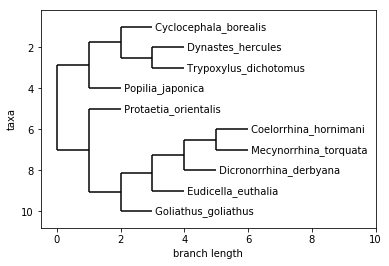

In [9]:
tree = Phylo.read(io.StringIO("(((Cyclocephala_borealis:1.0,(Dynastes_hercules:1.0,Trypoxylus_dichotomus:1.0):1.0):1.0,Popilia_japonica:1.0):1.0,(Protaetia_orientalis:1.0,((((Coelorrhina_hornimani:1.0,Mecynorrhina_torquata:1.0):1,Dicronorrhina_derbyana:1):1,Eudicella_euthalia:1.0):1,Goliathus_goliathus:1.0):1.0):1.0):0.0;"),
          "newick")

Phylo.draw(tree, xlim=(-0.5, 10))

With this tree in hand, we can now construct the covariance matrix given by the tree. The way that we do this is per ADD REF!!!!!!!!!!!!!!! where the the expected covariance of two species morphological measurements is given by the amount of shared ancestry of the taxa. We can implement this by calculating the total branch lengths from the most recent common ancestor of two species to the root of the tree.

In [10]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        if i == j:
            cov[i, j] = 6.0
            #continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec + ":" + comp
print("\n")
print("PGLS covariance matrix:")
print(cov.astype(int))
print("\n\n")
print("Species comparisons for the covariance matrix:")
pd.DataFrame(comp_matrix)



PGLS covariance matrix:
[[3 1 0 0 0 0 2 0 0 2]
 [1 2 0 0 0 0 1 0 0 1]
 [0 0 2 1 1 1 0 1 1 0]
 [0 0 1 6 3 4 0 5 2 0]
 [0 0 1 3 4 3 0 3 2 0]
 [0 0 1 4 3 5 0 4 2 0]
 [2 1 0 0 0 0 4 0 0 3]
 [0 0 1 5 3 4 0 6 2 0]
 [0 0 1 2 2 2 0 2 3 0]
 [2 1 0 0 0 0 3 0 0 4]]



Species comparisons for the covariance matrix:


0                                 1  \
0  Cyclocephala_borealis:Cyclocepha  Cyclocephala_borealis:Popilia_ja   
1  Popilia_japonica:Cyclocephala_bo  Popilia_japonica:Popilia_japonic   
2  Protaetia_orientalis:Cyclocephal  Protaetia_orientalis:Popilia_jap   
3  Coelorrhina_hornimani:Cyclocepha  Coelorrhina_hornimani:Popilia_ja   
4  Eudicella_euthalia:Cyclocephala_  Eudicella_euthalia:Popilia_japon   
5  Dicronorrhina_derbyana:Cycloceph  Dicronorrhina_derbyana:Popilia_j   
6  Trypoxylus_dichotomus:Cyclocepha  Trypoxylus_dichotomus:Popilia_ja   
7  Mecynorrhina_torquata:Cyclocepha  Mecynorrhina_torquata:Popilia_ja   
8  Goliathus_goliathus:Cyclocephala  Goliathus_goliathus:Popilia_japo   
9  Dynastes_hercules:Cyclocephala_b  Dynastes_hercules:Popilia_japoni   

                                  2                                 3  \
0  Cyclocephala_borealis:Protaetia_  Cyclocephala_borealis:Coelorrhin   
1  Popilia_japonica:Protaetia_orien  Popilia_japonica:Coelorrhina_hor   
2  Protaetia_orientalis:Protaetia_o  Protaetia_orientalis:Coelorrhina   
3  Coelorrhina_hornimani:Protaetia_  Coelorrhina_hornimani:Coelorrhin   
4  Eudicella_euthalia:Protaetia_ori  Eudicella_euthalia:Coelorrhina_h   
5  Dicronorrhina_derbyana:Protaetia  Dicronorrhina_derbyana:Coelorrhi   
6  Trypoxylus_dichotomus:Protaetia_  Trypoxylus_dichotomus:Coelorrhin   
7  Mecynorrhina_torquata:Protaetia_  Mecynorrhina_torquata:Coelorrhin   
8  Goliathus_goliathus:Protaetia_or  Goliathus_goliathus:Coelorrhina_   
9  Dynastes_hercules:Protaetia_orie  Dynastes_hercules:Coelorrhina_ho   

                                  4                                 5  \
0  Cyclocephala_borealis:Eudicella_  Cyclocephala_borealis:Dicronorrh   
1  Popilia_japonica:Eudicella_eutha  Popilia_japonica:Dicronorrhina_d   
2  Protaetia_orientalis:Eudicella_e  Protaetia_orientalis:Dicronorrhi   
3  Coelorrhina_hornimani:Eudicella_  Coelorrhina_hornimani:Dicronorrh   
4  Eudicella_euthalia:Eudicella_eut  Eudicella_euthalia:Dicronorrhina   
5  Dicronorrhina_derbyana:Eudicella  Dicronorrhina_derbyana:Dicronorr   
6  Trypoxylus_dichotomus:Eudicella_  Trypoxylus_dichotomus:Dicronorrh   
7  Mecynorrhina_torquata:Eudicella_  Mecynorrhina_torquata:Dicronorrh   
8  Goliathus_goliathus:Eudicella_eu  Goliathus_goliathus:Dicronorrhin   
9  Dynastes_hercules:Eudicella_euth  Dynastes_hercules:Dicronorrhina_   

                                  6                                 7  \
0  Cyclocephala_borealis:Trypoxylus  Cyclocephala_borealis:Mecynorrhi   
1  Popilia_japonica:Trypoxylus_dich  Popilia_japonica:Mecynorrhina_to   
2  Protaetia_orientalis:Trypoxylus_  Protaetia_orientalis:Mecynorrhin   
3  Coelorrhina_hornimani:Trypoxylus  Coelorrhina_hornimani:Mecynorrhi   
4  Eudicella_euthalia:Trypoxylus_di  Eudicella_euthalia:Mecynorrhina_   
5  Dicronorrhina_derbyana:Trypoxylu  Dicronorrhina_derbyana:Mecynorrh   
6  Trypoxylus_dichotomus:Trypoxylus  Trypoxylus_dichotomus:Mecynorrhi   
7  Mecynorrhina_torquata:Trypoxylus  Mecynorrhina_torquata:Mecynorrhi   
8  Goliathus_goliathus:Trypoxylus_d  Goliathus_goliathus:Mecynorrhina   
9  Dynastes_hercules:Trypoxylus_dic  Dynastes_hercules:Mecynorrhina_t   

                                  8                                 9  
0  Cyclocephala_borealis:Goliathus_  Cyclocephala_borealis:Dynastes_h  
1  Popilia_japonica:Goliathus_golia  Popilia_japonica:Dynastes_hercul  
2  Protaetia_orientalis:Goliathus_g  Protaetia_orientalis:Dynastes_he  
3  Coelorrhina_hornimani:Goliathus_  Coelorrhina_hornimani:Dynastes_h  
4  Eudicella_euthalia:Goliathus_gol  Eudicella_euthalia:Dynastes_herc  
5  Dicronorrhina_derbyana:Goliathus  Dicronorrhina_derbyana:Dynastes_  
6  Trypoxylus_dichotomus:Goliathus_  Trypoxylus_dichotomus:Dynastes_h  
7  Mecynorrhina_torquata:Goliathus_  Mecynorrhina_torquata:Dynastes_h  
8  Goliathus_goliathus:Goliathus_go  Goliathus_goliathus:Dynastes_her  
9  Dynastes_hercules:Goliathus_goli  Dynastes_hercules:Dynastes_hercu

With our data in this format, we can build the PGLS model for our regression. To do this, we will write a statistical model for the data. We choose a multivariate normal distribution with covariance matrix given by the above matrix adjusted by the parameter $\lambda$ (as in PGLS), and put a prior on $\lambda$. This gives

\begin{align}
f(x_i; a, b) &= ax_i + b \\
b &\sim \text{Norm}(0, 1) \\
a &\sim \text{Norm}(0, 2) \\
\lambda &\sim \text{beta}(1.1, 1.1) \\
y_i &\sim \text{multi_normal}\left(f_\mu(x_i; a, b), f_\sigma(\mathrm{cov}, \lambda)\right)
\end{align}


Time for a prior predictive check on our model!

In [11]:
sm_prior_pred = cmdstanpy.CmdStanModel(
    stan_file="spiracle_pgls_prior_predictive.stan"
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_prior_predictive.exe


In [12]:
x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '1', 'log mass (g)'].values

data = {
    "N": len(x),
    "x": x,
    "a_mu": 0.66,
    "a_sig": 0.3,
    "b_mu": -1.0,
    "b_sig": 1.0,
    "lambda_alpha": 1.1,
    "lambda_beta": 1.1,
    "cov_phylo":cov,
}

samples = sm_prior_pred.sample(data=data, sampling_iters=1000, fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [13]:
samples = az.from_cmdstanpy(posterior=samples, prior=samples, prior_predictive=['y'])

In [14]:
bokeh.io.show(
    
    bebi103.viz.predictive_regression(
        samples.prior_predictive['y'],
        samples_x=x,
        percentiles=[30, 60, 90, 99],
        x_axis_label='mass',
        y_axis_label='area',
    )
)

In [15]:
p = bokeh.plotting.figure()
p.circle('log mass (g)', 'log area (mm^2)', source=df_averages.loc[df_averages['spiracle'] == '1'])
bokeh.io.show(p)

In [16]:
size = 1000
lines = [a*x+b+sample for a, b, sample in zip(np.random.normal(0,2, size=size), np.random.normal(0,1,size=size),
                                              np.random.multivariate_normal(x, cov, size=size))]#+np.random.normal(0, 3, size=(100,) ))]

In [17]:
p = bokeh.plotting.figure()
[p.line(x, y, alpha=0.2) for y in lines]
bokeh.io.show(p)

In [18]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        #if i == j:
        #    cov[i, j] = 6.0
        #    continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec + ':' + comp

In [19]:
size = 1000
lines = [a*x+b+sample for a, b, sample in zip(np.random.normal(0,2, size=size), np.random.normal(0,1,size=size),
                                              np.random.multivariate_normal(x, cov, size=size))]#+np.random.normal(0, 3, size=(100,) ))]

In [20]:
p = bokeh.plotting.figure()
[p.line(x, y, alpha=0.2) for y in lines]
bokeh.io.show(p)

In [21]:
cov

array([[3., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 2., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 4., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 5., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 4., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 3., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 4.]])

In [22]:
plots = []
sample = np.random.multivariate_normal(x, cov, size=1000)
num = df_averages.sort_values('mass (g)').loc[df_averages.sort_values('mass (g)')['spiracle']=='1', 'subfam_count'].values
for i in range(len(sample[0])):
    for j in range(len(sample[0]))[i:-1]:
        p = bokeh.plotting.figure(plot_width=200, plot_height=200, x_range=(-5, 5), y_range=(-5, 5), title='comp of ' +str(i)+' and '+str(j)+' | '+str(num[i])+','+str(num[j]))
        p.circle(sample[:, i], sample[:, j], alpha=0.1)
        plots.append(p)

In [23]:
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

In [24]:
p = bokeh.plotting.figure()
[p.circle(x, sample, alpha=0.05) for sample in np.random.multivariate_normal(x, cov, size=1000)]
bokeh.io.show(p)

In [25]:
print(df_averages.sort_values('mass (g)').loc[df_averages.sort_values('mass (g)')['spiracle']=='1', 'subfam_count'].values)

[3 1 6 6 6 6 3 6 6 3]


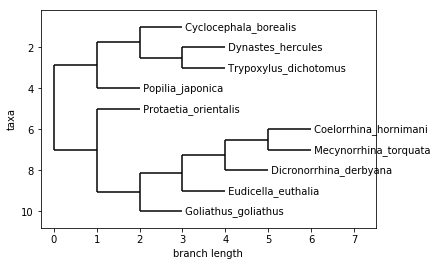

In [26]:
Phylo.draw(tree)

In [27]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        if i == j:
            cov[i, j] = 6.0
            #continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec + ':' + comp

In [28]:
cov#*1/1000

array([[3., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 2., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 4., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 5., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 4., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 3., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 4.]])

In [29]:
cov

array([[3., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 2., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 4., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 5., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 4., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 3., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 4.]])

In [88]:
df_averages.head()

species     species_underscore spiracle  area (mm^2)  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1     0.135347   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2     0.084207   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3     0.106693   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4     0.115574   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5     0.119145   

   depth (mm)  mass (g)   subfamily  subfam_count  log area (mm^2)  log dist  \
0    0.416717      1.13  Cetoniinae             6        -0.868551 -0.380159   
1    0.451409      1.13  Cetoniinae             6        -1.074651 -0.345430   
2    0.325444      1.13  Cetoniinae             6        -0.971862 -0.487524   
3    0.481558      1.13  Cetoniinae             6        -0.937142 -0.317351   
4    0.506751      1.13  Cetoniinae             6        -0.923923 -0.295205   

   log mass (g)  log area/dist  log area^2/dist  
0      0.053078      -0.488392        -1.356943  
1      0.053078      -0.729221        -1.803872  
2      0.053078      -0.484339        -1.456201  
3      0.053078      -0.619790        -1.556932  
4      0.053078      -0.628717        -1.552640

In [296]:
all_summaries = {}
for morphs, iso in zip(['log area (mm^2)', 'log dist', 'log area/dist', 'log area^2/dist'], [0.67, 0.33, 0.33, 1.0]):

    sigmas = []
    slopes = []
    intercepts = []
    summaries = {}
    for spir in ['S', 'T', '1', '2', '3', '4', '5', '6']:
        x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log mass (g)'].values
        y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, morphs].values

        data = {
            "N": len(x),
            "x": x,
            "y": y,
            "priora": iso,
            "cov_phylo":cov,
        }

        sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

        samples = sm.sample(data=data, sampling_iters=1000, chains=4)

        samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])
        p = bebi103.viz.corner(samples, pars=["a", "b", "lambda", "sigma"], xtick_label_orientation=np.pi / 4).children[1].children[5][0]
        p.line(np.linspace(0, 1, 200), scipy.stats.beta.pdf(np.linspace(0, 1, 200), 1.4, 1.4), line_width=8, alpha=0.5)
        bokeh.io.show(p)
        bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a', 'sigma', 'lambda'])
        sigmas.append(samples.posterior['sigma'].values.ravel())
        slopes.append(samples.posterior['a'].values.ravel())
        intercepts.append(samples.posterior['b'].values.ravel())
        summaries[spir] = az.summary(samples, var_names=['b', 'a', 'sigma'])
        summaries[spir]['median'] = [np.median(samples.posterior['b'].values.ravel()),
                                     np.median(samples.posterior['a'].values.ravel()),
                                     np.median(samples.posterior['sigma'].values.ravel())]
    all_summaries[morphs] = summaries

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
1 of 4000 (0.025%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


In [297]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    bs_σ_reps = np.empty(size)

    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        p, residuals, rank, singular_values, rcond = np.polyfit(bs_x, bs_y, deg=1, full=True)
        bs_slope_reps[i], bs_intercept_reps[i] = p#np.polyfit(bs_x, bs_y, deg=1, full=True)
        bs_σ_reps[i] = np.sqrt(residuals/(len(x)-2))

    return bs_slope_reps, bs_intercept_reps, bs_σ_reps

def make_CIs(df, to_plot, spiracle, q=[2.5, 97.5]):
    bs_slope_reps, bs_intercept_reps, bs_σ_reps  = draw_bs_pairs_linreg(
                        df.loc[(df['spiracle'] == spiracle), 'log mass (g)'].values,
                        df.loc[(df['spiracle'] == spiracle), to_plot].values,
                                                        size=10000)
    
    p, residuals, rank, singular_values, rcond = np.polyfit(df.loc[(df['spiracle'] == spiracle), 'log mass (g)'].values, 
                                  df.loc[(df['spiracle'] == spiracle), to_plot].values, deg=1, full=True)
    slope, intercept = p
    σ = np.sqrt(residuals/(len(df.loc[(df['spiracle'] == spiracle), 'log mass (g)'].values)-2))
        
    return(np.percentile(bs_slope_reps, q), np.percentile(bs_intercept_reps, q), np.percentile(bs_σ_reps, q), slope, intercept, σ)

In [298]:
plots = []
for morphs, iso, heading in zip(['log area (mm^2)', 'log dist', 'log area/dist', 'log area^2/dist'], [0.67, 0.33, 0.33, 1.0], ['Area', 'Depth', 'Diffusive', 'Advective']):
    print(morphs)
    summaries = all_summaries[morphs]
    for var, yax, var_title in zip(['a', 'b', 'sigma'], ['log-log slope', 'intercept (mm^2)', 'log-log sigma'], ['slope', 'intercept', 'variance']):
        p = bokeh.plotting.figure(plot_height=200, plot_width=300, x_range=['S', 'T', '1', '2', '3', '4', '5', '6'], title=heading + ', Median ± HPD for ' + var_title, y_axis_label=yax, x_axis_label='Spiracle')#, y_axis_type='log')
        if var == 'a':
                p.line([-10, 100], [iso, iso], color='black', line_width=2, line_alpha=1)
        for i, spir in enumerate(['S', 'T', '1', '2', '3', '4', '5', '6']):
            CI_a, CI_b, CI_σ, slope, intercept, σ = make_CIs(df_averages, morphs, spir)
            
            if var == 'b':
                p.line([spir, spir], 10**np.array([summaries[spir].loc[var]['hpd_3%'], summaries[spir].loc[var]['hpd_97%']]), color='grey', line_width=7, alpha=0.75)
                
                p.line([spir, spir], 10**CI_b, color='black', line_width=2, alpha=0.75)
                p.diamond([spir,], 10**summaries[spir].loc[var]['median'], color='white', size=9, alpha=1)
                p.diamond([spir,], 10**intercept, color='black', size=3)
            elif var == 'a':
                p.line([spir, spir], [summaries[spir].loc[var]['hpd_3%'], summaries[spir].loc[var]['hpd_97%']], color='grey', line_width=7, alpha=0.75)
                p.line([spir, spir], CI_a, color='black', line_width=2, alpha=0.75)
                p.diamond([spir,], summaries[spir].loc[var]['median'], color='white', size=9, alpha=1)
                p.diamond([spir,], slope, color='black', size=3)
            else:
                p.line([spir, spir], np.array([summaries[spir].loc[var]['hpd_3%'], summaries[spir].loc[var]['hpd_97%']])*np.mean([cov[i, i] for i in range(len(cov))]),
                       color='grey', line_width=7, alpha=0.75)
                p.line([spir, spir], CI_σ, color='black', line_width=2, alpha=0.75)
                p.diamond([spir,], summaries[spir].loc[var]['median']*np.mean([cov[i, i] for i in range(len(cov))]), color='white', size=9, alpha=1)
                p.diamond([spir,], σ, color='black', size=3)

        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None
        p.output_backend = 'svg'
        plots.append(p)
        #bokeh.io.show(p)

log area (mm^2)
log dist
log area/dist
log area^2/dist


In [299]:
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

In [153]:
p = bokeh.plotting.figure(plot_height=200, plot_width=350, y_axis_type='log')

for i, sig in enumerate(sigmas):
    p.circle([i,], 10**np.percentile(sig, q=[50, ]), color='black', size=20)
    p.line([i, i], 10**np.percentile(sig, q=[2.5, 97.5]), color='grey', line_width=7)

    #p.square([i, i], np.percentile(sig, q=[2.5, 97.5]), color='grey', size=12)
    
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.output_backend = 'svg'
bokeh.io.show(p)

In [151]:
p = bokeh.plotting.figure(plot_height=200, plot_width=350, title='Slope area/depth')

p.line([0, 7], [0.66, 0.66], color='grey', line_width=3, line_alpha=0.5)

for i, sig in enumerate(slopes):
    p.circle([i,], np.percentile(sig, q=[50, ]), color='black', size=20)
    p.line([i, i], np.percentile(sig, q=[2.5, 97.5]), color='grey', line_width=7)

    #p.square([i, i], np.percentile(sig, q=[2.5, 97.5]), color='grey', size=12)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.output_backend = 'svg'
bokeh.io.show(p)

In [164]:
p = bokeh.plotting.figure(plot_height=200, plot_width=350, title='Area at intercept')

for i, sig in enumerate(intercepts):
    p.circle([i,], 10**np.percentile(sig, q=[50, ]), color='black', size=7)
    p.line([i, i], 10**np.percentile(sig, q=[2.5, 97.5]), color='grey', line_width=7, alpha=0.75)

    #p.square([i, i], np.percentile(sig, q=[2.5, 97.5]), color='grey', size=12)
    
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.output_backend = 'svg'
bokeh.io.show(p)

In [ ]:
barx = df_summary.loc[["hpd_low", "hpd_high"], name]


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b     -1.502  0.155  -1.772   -1.181      0.003    0.002    2359.0  2359.0   
a      0.529  0.157   0.226    0.814      0.003    0.002    2348.0  2348.0   
sigma  0.455  0.130   0.252    0.696      0.003    0.002    2296.0  2220.0   

       ess_bulk  ess_tail  r_hat  
b        2469.0    1907.0    1.0  
a        2389.0    2127.0    1.0  
sigma    2540.0    2331.0    1.0

In [133]:
p = bokeh.plotting.figure()
for i, sig in enumerate(sigmas):
    p.circle([i, i], np.percentile(sig, q=[2.5, 97.5]), color='grey', size=12)
    p.circle([i,], np.percentile(sig, q=[50, ]), color='black', size=20)
bokeh.io.show(p)

In [99]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "sigma"], xtick_label_orientation=np.pi / 4
    )
)

In [92]:
az.summary(samples, var_names=['b', 'a', 'sigma'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b     -1.504  0.154  -1.807   -1.229      0.003    0.002    2714.0  2714.0   
a      0.532  0.156   0.229    0.813      0.003    0.002    2700.0  2700.0   
sigma  0.448  0.123   0.257    0.679      0.003    0.002    2194.0  2173.0   

       ess_bulk  ess_tail  r_hat  
b        2775.0    2175.0    1.0  
a        2691.0    2696.0    1.0  
sigma    2301.0    2585.0    1.0

In [93]:
print(az.summary(samples, var_names=['b', 'a'])['mean']['a'] + az.summary(samples, var_names=['b', 'a'])['sd']['a']*1.96)
print(az.summary(samples, var_names=['b', 'a'])['mean']['a'] - az.summary(samples, var_names=['b', 'a'])['sd']['a']*1.96)

0.8377600000000001
0.22624000000000005


In [300]:
spir = '6'
to_plot = 'log area^2/dist'
p = bokeh.plotting.figure(x_axis_label='log mass', y_axis_label='log area')


############################################
############################################
############################################

p_alpha = 0.15
# x-values
x = np.linspace(x.min(), x.max(), 200)

# y-values of each point
y = np.outer(samples.posterior['a'].values[0], x) + np.stack([samples.posterior['b'].values[0]]*200, axis=1)

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [2.5, 97.5], axis=0)

p1 = np.append(x, x[::-1])
p2 = np.append(low, high[::-1])

p.patch(p1, p2, alpha=p_alpha, color='grey')

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [10, 90], axis=0)

p1 = np.append(x, x[::-1])
p2 = np.append(low, high[::-1])

p.patch(p1, p2, alpha=p_alpha, color='grey')

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [20, 80], axis=0)

p1 = np.append(x, x[::-1])
p2 = np.append(low, high[::-1])

p.patch(p1, p2, alpha=p_alpha, color='grey')
############################################
############################################
############################################

x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log mass (g)'].values
y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, to_plot].values


Y = df.sort_values('mass (g)').loc[df['spiracle'] == spir, to_plot].values
X = df.sort_values('mass (g)').loc[df['spiracle'] == spir, 'log mass (g)'].values
X = statsmodels.api.add_constant(X)
model = statsmodels.api.OLS(Y,X)
results = model.fit()
results.params


p.circle(df.sort_values('mass (g)').loc[df['spiracle'] == spir, 'log mass (g)'].values,
         df.sort_values('mass (g)').loc[df['spiracle'] == spir, to_plot].values, color='black', size=15, alpha=0.3, fill_color='green')

p.line(np.linspace(x.min(), x.max(), 200),
       results.params[1]*np.linspace(x.min(), x.max(), 200) + results.params[0],
       line_width=5, line_dash='dashed', color='orange', alpha=0.3, legend_label='OLS all data')


Y = y
X = x
X = statsmodels.api.add_constant(X)
model = statsmodels.api.OLS(Y,X)
results = model.fit()
results.params

p.line(np.linspace(x.min(), x.max(), 200),
       az.summary(samples, var_names=['b', 'a'])['mean']['a']*np.linspace(x.min(), x.max(), 200) + az.summary(samples, var_names=['b', 'a'])['mean']['b'],
       line_width=5, color='black', legend_label='Average parameter MCMC reggression')

p.line(np.linspace(x.min(), x.max(), 200),
       results.params[1]*np.linspace(x.min(), x.max(), 200) + results.params[0],
       line_width=5, line_dash='dashed', color='grey', legend_label='OLS averages')

p.circle(x, y, color='black', size=15, alpha=0.5, fill_color='red')

p.legend.location = 'bottom_right'

bokeh.io.show(p)

In [70]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 95],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1, x.max()+0.1],
    )
)

In [ ]:
spir = 'S'

x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log mass (g)'].values
y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log area/dist'].values

data = {
    "N": len(x),
    "x": x,
    "y": y,
    "cov_phylo":cov,
}


In [32]:
sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [33]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a'])

Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

With our data in this format, we can build the PGLS model for our regression. To do this, we will write a statistical model for the data. We choose a multivariate normal distribution with covariance matrix given by the above matrix adjusted by the parameter $\lambda$ (as in PGLS), and put a prior on $\lambda$. This gives

\begin{align}
f(x_i; a, b) &= ax_i + b \\
b &\sim \text{Norm}(0, 1) \\
a &\sim \text{Norm}(0, 2) \\
\lambda &\sim \text{beta}(1.1, 1.1) \\
y_i &\sim \text{multi_normal}\left(f_\mu(x_i; a, b), f_\sigma(\mathrm{cov}, \lambda)\right)
\end{align}


In [34]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "lambda", "sigma"], xtick_label_orientation=np.pi / 4
    )
)

In [35]:
p = bebi103.viz.corner(samples, pars=["a", "b", "lambda", "sigma"], xtick_label_orientation=np.pi / 4).children[1].children[5][0]
p.line(np.linspace(0, 1, 200), scipy.stats.beta.pdf(np.linspace(0, 1, 200), 1.4, 1.4), line_width=8, alpha=0.5)
bokeh.io.show(p)

In [36]:
p = bokeh.plotting.figure()
norm = np.linspace(-1, 1.5, 200)

bebi103.viz.ecdf(samples.posterior['a'].values.ravel(), color='red', p=p)

p.line(norm, scipy.stats.norm.cdf(norm, 0.33, 0.3))

bokeh.io.show(p)

In [37]:
az.summary(samples, var_names=['b', 'a', 'lambda'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b      -0.194  0.098  -0.386   -0.018      0.002    0.001    2674.0  2197.0   
a       0.422  0.057   0.304    0.524      0.001    0.001    3344.0  3178.0   
lambda  0.501  0.263   0.083    0.961      0.004    0.003    4424.0  3879.0   

        ess_bulk  ess_tail  r_hat  
b         2999.0    1929.0    1.0  
a         3414.0    2306.0    1.0  
lambda    4290.0    2701.0    1.0

In [38]:
az.summary(samples, var_names=['b', 'a'])['mean']['a'] + az.summary(samples, var_names=['b', 'a'])['sd']['a']*1.96

0.53372

In [39]:
az.summary(samples, var_names=['b', 'a'])['mean']['a'] - az.summary(samples, var_names=['b', 'a'])['sd']['a']*1.96

0.31028

In [40]:
bokeh.io.show(bebi103.viz.ecdf(samples.posterior['a'].values.ravel()-0.333))

In [41]:
np.sum(samples.posterior['a'].values.ravel()-0.333 < 0)/len(samples.posterior['a'].values.ravel())

0.05575

In [42]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 95],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1, x.max()+0.1],
    )
)

In [43]:
spir = 'S'
p = bokeh.plotting.figure(x_axis_label='log mass', y_axis_label='log area')


############################################
############################################
############################################

p_alpha = 0.15
# x-values
x = np.linspace(x.min(), x.max(), 200)

# y-values of each point
y = np.outer(samples.posterior['a'].values[0], x) + np.stack([samples.posterior['b'].values[0]]*200, axis=1)

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [2.5, 97.5], axis=0)

p1 = np.append(x, x[::-1])
p2 = np.append(low, high[::-1])

p.patch(p1, p2, alpha=p_alpha, color='grey')

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [10, 90], axis=0)

p1 = np.append(x, x[::-1])
p2 = np.append(low, high[::-1])

p.patch(p1, p2, alpha=p_alpha, color='grey')

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [20, 80], axis=0)

p1 = np.append(x, x[::-1])
p2 = np.append(low, high[::-1])

p.patch(p1, p2, alpha=p_alpha, color='grey')
############################################
############################################
############################################

x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log mass (g)'].values
y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log area/dist'].values


Y = df.sort_values('mass (g)').loc[df['spiracle'] == spir, 'log area/dist'].values
X = df.sort_values('mass (g)').loc[df['spiracle'] == spir, 'log mass (g)'].values
X = statsmodels.api.add_constant(X)
model = statsmodels.api.OLS(Y,X)
results = model.fit()
results.params


p.circle(df.sort_values('mass (g)').loc[df['spiracle'] == spir, 'log mass (g)'].values,
         df.sort_values('mass (g)').loc[df['spiracle'] == spir, 'log area/dist'].values, color='black', size=15, alpha=0.3, fill_color='green')

p.line(np.linspace(x.min(), x.max(), 200),
       results.params[1]*np.linspace(x.min(), x.max(), 200) + results.params[0],
       line_width=5, line_dash='dashed', color='orange', alpha=0.3, legend_label='OLS all data')


Y = y
X = x
X = statsmodels.api.add_constant(X)
model = statsmodels.api.OLS(Y,X)
results = model.fit()
results.params

p.line(np.linspace(x.min(), x.max(), 200),
       az.summary(samples, var_names=['b', 'a'])['mean']['a']*np.linspace(x.min(), x.max(), 200) + az.summary(samples, var_names=['b', 'a'])['mean']['b'],
       line_width=5, color='black', legend_label='Average parameter MCMC reggression')

p.line(np.linspace(x.min(), x.max(), 200),
       results.params[1]*np.linspace(x.min(), x.max(), 200) + results.params[0],
       line_width=5, line_dash='dashed', color='grey', legend_label='OLS averages')

p.circle(x, y, color='black', size=15, alpha=0.5, fill_color='red')

p.legend.location = 'bottom_right'

bokeh.io.show(p)

In [41]:
p = bokeh.plotting.figure(x_axis_label='log mass', y_axis_label='log area')

p.circle(df.sort_values('mass (g)').loc[df['spiracle'] == '1', 'log mass (g)'].values,
         df.sort_values('mass (g)').loc[df['spiracle'] == '1', 'log area (mm^2)'].values, color='black', size=15, alpha=0.8, fill_color='red')

bokeh.io.show(p)

In [42]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        
        comp_matrix[i, j] = spec + ':' + comp
        
        if i == j:
            cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
            continue
            
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        
cov

array([[3., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 2., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 4., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 5., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 4., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 3., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 4.]])

In [43]:
cov=np.linalg.inv(cov)
print(pd.DataFrame(np.round(cov, decimals=3)))

       0      1      2      3      4      5      6      7      8      9
0  0.571 -0.143  0.000  0.000  0.000  0.000 -0.143  0.000  0.000 -0.143
1 -0.143  0.619  0.000  0.000  0.000  0.000 -0.048  0.000  0.000 -0.048
2  0.000  0.000  0.618 -0.007 -0.056 -0.021  0.000 -0.007 -0.146  0.000
3  0.000  0.000 -0.007  0.618 -0.056 -0.146  0.000 -0.382 -0.021  0.000
4  0.000  0.000 -0.056 -0.056  0.556 -0.167  0.000 -0.056 -0.167  0.000
5  0.000  0.000 -0.021 -0.146 -0.167  0.562  0.000 -0.146 -0.062  0.000
6 -0.143 -0.048  0.000  0.000  0.000  0.000  0.619  0.000  0.000 -0.381
7  0.000  0.000 -0.007 -0.382 -0.056 -0.146  0.000  0.618 -0.021  0.000
8  0.000  0.000 -0.146 -0.021 -0.167 -0.062  0.000 -0.021  0.562  0.000
9 -0.143 -0.048  0.000  0.000  0.000  0.000 -0.381  0.000  0.000  0.619


In [44]:
x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '3', 'log mass (g)'].values
y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '3', 'log area (mm^2)'].values

data = {
    "N": len(x),
    "x": x,
    "y": y,
    "cov_phylo":cov,
}


In [45]:
sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [46]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a', 'lambda'])

Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

In [47]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "lambda"], xtick_label_orientation=np.pi / 4
    )
)

In [48]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 99],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1, x.max()+0.1],
    )
)

In [49]:
p = bokeh.plotting.figure()
p.line(np.linspace(-1, 1.5, 200), np.linspace(-1, 1.5, 200)*0.7672-1.4551)
p.line(np.linspace(-1, 1.5, 200), np.linspace(-1, 1.5, 200)*0.5887-1.3282, color='red')
p.line(np.linspace(-1, 1.5, 200), np.linspace(-1, 1.5, 200)*az.summary(samples, var_names=['b', 'a', 'lambda'])['mean'][1]
       + az.summary(samples, var_names=['b', 'a', 'lambda'])['mean'][0], color='black')
p.circle(x, y, size=15)
bokeh.io.show(p)

In [50]:
az.summary(samples, var_names=['b', 'a', 'lambda'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b      -1.321  0.060  -1.437   -1.210      0.002    0.001    1456.0  1456.0   
a       0.564  0.110   0.366    0.784      0.003    0.002    1397.0  1397.0   
lambda  0.503  0.257   0.084    0.964      0.005    0.004    2983.0  2669.0   

        ess_bulk  ess_tail  r_hat  
b         1547.0    1487.0    1.0  
a         1477.0    1261.0    1.0  
lambda    2974.0    1866.0    1.0

In [51]:
library(nlme)
cat("((((Homo:0.21,Pongo:0.21):0.28,",
"Macaca:0.49):0.13,Ateles:0.62):0.38,Galago:1.00);",
file = "ex.tre", sep = "\n")
tree.primates <- read.tree("ex.tre")
X <- c(4.09434, 3.61092, 2.37024, 2.02815, -1.46968)
Y <- c(4.74493, 3.33220, 3.36730, 2.89037, 2.30259)
unlink("ex.tre") # delete the file "ex.tre"
m1 <- gls(Y ~ X, correlation=corBrownian(1, tree.primates))
corMatrix(m1$modelStruct$corStruct)
summary(m1)
m2 <- gls(Y ~ X, correlation=corMartins(1, tree.primates))
summary(m2)
corMatrix(m2$modelStruct$corStruct)
m3 <- gls(Y ~ X, correlation=corGrafen(1, tree.primates))
summary(m3)
corMatrix(m3$modelStruct$corStruct)

SyntaxError: invalid syntax (<ipython-input-51-8452e6f8c646>, line 9)

In [ ]:
tree = Phylo.read(io.StringIO("((((Homo:0.21,Pongo:0.21):0.28,Macaca:0.49):0.13,Ateles:0.62):0.38,Galago:1.00);"),
          "newick")

In [ ]:
Phylo.draw(tree)

In [ ]:
species = ["Homo","Pongo","Macaca","Ateles","Galago"]

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        
        comp_matrix[i, j] = spec + ':' + comp
        
        if i == j:
            cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
            continue
            
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        
pd.DataFrame(cov,index=species, columns=species)

In [ ]:
X = np.array((4.09434, 3.61092, 2.37024, 2.02815, -1.46968))
Y = np.array((4.74493, 3.33220, 3.36730, 2.89037, 2.30259))

In [ ]:
p = bokeh.plotting.figure()
p.circle(X, Y)

bokeh.io.show(p)

In [ ]:
data = {
    "N": len(X),
    "x": X,
    "y": Y,
    "cov_phylo":cov,
}

sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

In [ ]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a'])

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b"], xtick_label_orientation=np.pi / 4
    )
)

In [ ]:
az.summary(samples, ['a', 'b'])

In [ ]:
np.std(np.array(samples.posterior['a']))

In [ ]:
0.7754516*np.sqrt(5)

In [ ]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=X,
        percentiles=[30, 50, 70, 99],
        data=np.vstack((X, Y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[X.min()-0.1,X.max()+0.1],
    )
)

In [ ]:
bebi103.stan.clean_cmdstan()

In [ ]:
cov=[[3.0, 2.0, 1.0, 1.0, 0.0],
     [2.0, 3.0, 1.0, 1.0, 0.0],
     [1.0, 1.0, 3.0, 2.0, 0.0],
     [1.0, 1.0, 2.0, 3.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 3.0]]

In [ ]:
cov=np.array([[3.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 3.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 3.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 3.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 3.0]])*1/10

In [ ]:
x=np.array([1.02, 1.06, 0.96, 0.92, 0.89])
y=np.array([1.38, 1.41, 1.36, 1.22, 1.13])

In [ ]:
p = bokeh.plotting.figure()
p.circle(x, y)

bokeh.io.show(p)

In [ ]:
data = {
    "N": len(x),
    "x": x,
    "y": y,
    "cov_phylo":cov,
}

sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4, adapt_delta=0.99)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

In [ ]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a', 'lambda'])

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "lambda"], xtick_label_orientation=np.pi / 4
    )
)

In [ ]:
az.summary(samples, ['a', 'b', 'lambda'])

In [ ]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 99],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1,x.max()+0.1],
    )
)